<a href="https://colab.research.google.com/github/davidashirov/fast-ai-course/blob/main/knn_using_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ускоряем kNN с помощью GPU - Качок Доге стайл
## Поменяй сервер на GPU пжлст!

## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Pytorch &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;                / &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Scikit-learn

<img src="https://i.kym-cdn.com/entries/icons/original/000/034/084/cover6.jpg" alt="image" width="700" height="auto">


Scikit-learn медленный, потому что использует numpy/scipy для манипуляции массивами. Мы напишем свой kNN с Pytorch и CUDA ядрами и посмотрим кто окажется быстрее.

In [75]:
if not torch.cuda.is_available():
  raise Exception("Поменяй сервер на GPU!")

 Базовый анализ:

In [1]:
from keras.datasets import mnist
import numpy as np
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(f'{x_train.shape=} {y_train.shape=}')
print(f'{x_test.shape=} {y_test.shape=}')

11490434/11490434 [==============================] - 1s 0us/step
x_train.shape=(60000, 28, 28) y_train.shape=(60000,)
x_test.shape=(10000, 28, 28) y_test.shape=(10000,)


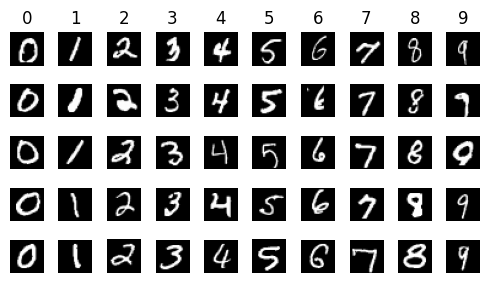

In [2]:
import matplotlib.pyplot as plt
# Plot the first few images
fig, axes = plt.subplots(5, 10, figsize=(5, 3))
for i in np.arange(0, 10):
  axes[0,i].set_title(i)
  for j in np.arange(0,5):
    digit = np.random.randint(x_train[y_train==i].shape[0])
    axes[j,i].imshow(x_train[y_train==i][digit], cmap='gray')
    axes[j,i].axis('off')
plt.tight_layout()

Наш класс kNN будет поддерживать веса точек - weights= 'uniform', 'distance' и расстояние Минковского metric = 'minkowski' с переменным p (default=2)

In [54]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class kNN():
  def __init__(self, n_neighbors,weights='uniform', p=2, *args, **kwargs):
    self.n_neighbors = n_neighbors
    self.weights = weights
    self.p = p

  def fit(self, X, y):
    self.X = torch.tensor(X,device=device,dtype=torch.float32)
    self.y = torch.tensor(y,device=device)

  def predict_proba(self, X_test):
    X_test = torch.tensor(X_test,device=device,dtype=torch.float32)
    X = self.X
    y = self.y

    distances = torch.cdist(X, X_test, p=self.p)
    distances_n_nearest, indices = torch.topk(distances, n_neighbors, largest=False, dim=0)

    n_nearest = y[indices] # N nearest digits: n, 10000 tensor
    digits = torch.arange(10,device=device)[:, None, None] # Digits 1-9: 10, 1, 1 tensor
    digit_counts_bool = (n_nearest==digits).to(device) # Broadcasting: 10, n, 10000 tensor

    if weights=='uniform':
      class_probas = digit_counts_bool.mean(dim=1, dtype=torch.float16) # collapse to 10,10000 tensor

    elif weights=='distance':
      # Inverse distance weights
      w = 1/distances_n_nearest # n, 10000
      # sum weights along dimension of nearest points
      sum_w = w.sum(dim=0,keepdim=True)  # 1, 10000
      # multiply each count by its weight and sum along counts dimension leaving 10, 10000 tensor
      class_probas = (digit_counts_bool*w).sum(dim=1)/sum_w # 10,n,10000 * 1,10000 -sum-> 10, 10000
    else:
      raise NotImplementedError()

    return class_probas.cpu().numpy()

  def predict(self, X_test):
    probas = self.predict_proba(X_test)
    pred_classes = probas.argmax( axis=0) # Find class with highest prob
    return pred_classes

In [47]:
from sklearn.neighbors import KNeighborsClassifier

n_neighbors = 7
weights = 'distance'
p = 2

In [48]:
%%time
print('Sklearn на CPU (он и может только на CPU)\n')
knn_sk = KNeighborsClassifier(n_neighbors=n_neighbors,weights=weights,p=p)

knn_sk.fit(x_train.reshape(x_train.shape[0],-1), y_train)
y_pred_sklearn = knn_sk.predict(x_test.reshape(x_test.shape[0],-1))

Sklearn на CPU (он и может только на CPU)

CPU times: user 41.6 s, sys: 3.65 s, total: 45.2 s
Wall time: 28.8 s


Sklearn у меня отработал за 45.2 секунд. Чтож, делаем ставки, как быстро сработает код на CPU / GPU

In [55]:
%%time
print('Pytorch на CPU')

device = 'cpu'
# Мой kNN написанный на Pytorch
knn_torch = kNN(n_neighbors,weights=weights,p=p)
knn_torch.fit(x_train.reshape(x_train.shape[0],-1), y_train)
y_pred_torch = knn_torch.predict(x_test.reshape(x_test.shape[0],-1))

Pytorch на CPU
CPU times: user 18.9 s, sys: 1.71 s, total: 20.6 s
Wall time: 20.6 s


Уже неплохо - 20.6 секунды. Я думал, что в Pytorch на CPU будет медленнее чем Sklearn из-за доп операций или неэффективных расчетов (программист я так себе). Теперь тестируем на GPU / CUDA.

In [56]:
%%time
print('Pytorch на GPU')
device = 'cuda'
# Мой kNN написанный на Pytorch
knn_torch = kNN(n_neighbors,weights=weights,p=p)
knn_torch.fit(x_train.reshape(x_train.shape[0],-1), y_train)
y_pred_torch = knn_torch.predict(x_test.reshape(x_test.shape[0],-1))

Pytorch на GPU
CPU times: user 1.27 s, sys: 97.3 ms, total: 1.37 s
Wall time: 1.35 s


1.35 секунд - неплохо. Но нужно проверить, что результат верный, сравнив с Sklearn:

In [57]:
np.all(y_pred_torch == y_pred_sklearn)

True

Большую часть времени занимает конвертация массивов между Numpy и Pytorch и неэффективный numpy.argmax() на CPU в функции predict(). Попробуем выводить Pytorch массивы  на выходе вместо конвертации в np.ndarray.

In [80]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class kNN():
  def __init__(self, n_neighbors,weights='uniform', p=2, *args, **kwargs):
    self.n_neighbors = n_neighbors
    self.weights = weights
    self.p = p

  def fit(self, X, y):
    self.X = torch.tensor(X,device=device,dtype=torch.float32)
    self.y = torch.tensor(y,device=device)

  def predict_proba(self, X_test):
    X_test = torch.tensor(X_test,device=device,dtype=torch.float32)
    X = self.X
    y = self.y

    distances = torch.cdist(X, X_test, p=self.p)
    distances_n_nearest, indices = torch.topk(distances, n_neighbors, largest=False, dim=0)

    n_nearest = y[indices] # N nearest digits: n, 10000 tensor
    digits = torch.arange(10,device=device)[:, None, None] # Digits 1-9: 10, 1, 1 tensor
    digit_counts_bool = (n_nearest==digits).to(device) # Broadcasting: 10, n, 10000 tensor

    if weights=='uniform':
      class_probas = digit_counts_bool.mean(dim=1, dtype=torch.float16) # collapse to 10,10000 tensor

    elif weights=='distance':
      # Inverse distance weights
      w = 1/distances_n_nearest # n, 10000
      # sum weights along dimension of nearest points
      sum_w = w.sum(dim=0,keepdim=True)  # 1, 10000
      # multiply each count by its weight and sum along counts dimension leaving 10, 10000 tensor
      class_probas = (digit_counts_bool*w).sum(dim=1)/sum_w # 10,n,10000 * 1,10000 -sum-> 10, 10000
    else:
      raise NotImplementedError()

    return class_probas

  def predict(self, X_test):
    probas = self.predict_proba(X_test)
    pred_classes = probas.argmax(dim=0) # Find class with highest prob
    return pred_classes

In [82]:
%%time
print('Pytorch на GPU')
device = 'cuda'
# Мой kNN написанный на Pytorch
knn_torch = kNN(n_neighbors,weights=weights,p=p)
knn_torch.fit(x_train.reshape(x_train.shape[0],-1), y_train)
y_pred_torch = knn_torch.predict(x_test.reshape(x_test.shape[0],-1))

Pytorch на GPU
CPU times: user 74.4 ms, sys: 87.9 ms, total: 162 ms
Wall time: 164 ms


164 миллисекунды на расчет. Куда лучше. Ну а теперь проверим Confusion Matrix, Precision, Recall модели.

In [83]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
y_pred_torch = y_pred_torch.cpu().numpy()

confusion = confusion_matrix(y_pred_torch, y_test)
precision = precision_score(y_pred_torch, y_test, labels=np.arange(10),average=None)
recall = recall_score(y_pred_torch, y_test, labels=np.arange(10),average=None)

<Axes: >

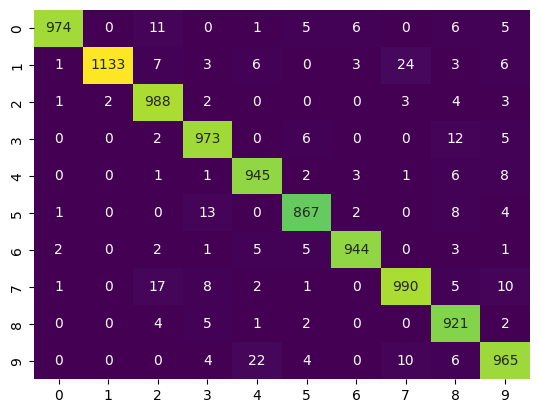

In [91]:
import seaborn as sns
sns.heatmap(confusion, annot=True, fmt='g', cmap = 'viridis', cbar=False)

In [93]:
for i in range(10):
  print(f'{i}: precision = {precision[i]}, recall = {recall[i]}')

0: precision = 0.9938775510204082, recall = 0.9662698412698413
1: precision = 0.9982378854625551, recall = 0.9553119730185498
2: precision = 0.9573643410852714, recall = 0.9850448654037887
3: precision = 0.9633663366336633, recall = 0.9749498997995992
4: precision = 0.9623217922606925, recall = 0.9772492244053774
5: precision = 0.9719730941704036, recall = 0.9687150837988827
6: precision = 0.9853862212943633, recall = 0.980269989615784
7: precision = 0.9630350194552529, recall = 0.9574468085106383
8: precision = 0.9455852156057495, recall = 0.9850267379679144
9: precision = 0.956392467789891, recall = 0.9545004945598418
